In [75]:
import csv
import numpy as np
import ROOT as rt
from glob import glob

In [76]:
Energy_cs = np.array([0.185, 0.477, 0.662])
Energy_na = np.array([0.170, 0.341, 0.511, 1.057, 1.27])

#gain = 76005 # gain of SensL J1 (broke)
# gain = 76220.3 #gain of sensL j_2
# gain = 73471.6 # sensL J_5 with 52+
# gain = 80470.4 #sensL J_4 74+
gain = 82085.1 #SensL j_33_35_3
# gain = 47730.8 #SensL_j_44_35_1
# gain = 39548.6 #Senl_C_33_20_4
PDE = 0.5 # PDE assumption for SensL J series
# PDE = 0.31
#PDE = 0.25 # pde of hamamatsu surface mount from spec sheet, at V = 58V, V_over = 5V
Ch2N = 1.0e-12/1.6e-19



In [77]:
na = open('../data/181031_Sensl_J_33_3_Saturation/Na22_tile_8x8x4_SensL_J_33_3_OV30V.csv')
cs = open('../data/181031_Sensl_J_33_3_Saturation/Cs137_tile_8x8x4_SensL_J_33_3_OV30V.csv')
# single_pe = open('../data/18_10_24_sensL_J33_singlephoton/JLaser_tune90_ND1_singlephoton_SL_J33_3_OV30V_NoExtAmp.csv')
# cs = open('../data/181107_SensL_crystal_test/Cs137_8x8x4mm_tile_Snl_44J35_1_OV30V_th8mV.csv')
# na = open('../data/181107_SensL_crystal_test/Na22_8x8x4mm_tile_Snl_44J35_1_OV30V_th8mV.csv')
# cs = open('../data/181107_SensL_crystal_test/Cs137_8x8x4mm_tile_Snl_33C20_4_OV30V_th5mV.csv')
# na = open('../data/181107_SensL_crystal_test/Na22_8x8x4mm_tile_Snl_33C20_4_OV30V.csv')




f = na
Amp_x_R = 50 * 10
content = csv.reader(f)


x = []
y = []
for r in content:
    x.append(1e12*float(r[0]) / Amp_x_R)
    y.append(float(r[1]))

h = rt.TH1F('h', 'h', int(len(x)), x[0], x[-1])
# h.GetXaxis().SetLimits(h.FindBin(-300), h.FindBin(0))
h.SetXTitle('Charge [pC]')
h.SetYTitle('Events / {:1.1e} pC'.format(h.GetBinWidth(1)))
for i in range(len(x)):
    h.SetBinContent(i+1, y[i])

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


In [78]:
SS = rt.TSpectrum()
n_pks = SS.Search(h, 4, "", 0.007)
x_pos = SS.GetPositionX()
y_pos = SS.GetPositionY()
pks = []
print n_pks
for i in range(n_pks):
    pks.append((x_pos[i],y_pos[i]))
       
pks.sort(key=lambda tup: tup[0])
# pks = pks[n_pks-len(Energy_na):]
# pks = [pks[4],pks[8],pks[9],pks[10],pks[11]]
pks = [pks[4],pks[6],pks[7],pks[8],pks[9]]


x_pos = []
y_pos = []
for x,y in pks:
    x_pos.append(x)
    y_pos.append(y)
print x_pos,y_pos
              

10
[12.620133843212242, 20.53317399617591, 27.813170936902495, 40.39490478011473, 44.11403365200765] [360.0, 194.0, 839.0, 66.0, 104.0]


In [79]:
multi = rt.TMultiGraph()
saturation = rt.TGraphErrors(20)
linear = rt.TGraphErrors(3)
#Energy = np.array([0, 0.511])
Energy = Energy_na
N_pe = 0*Energy


for i in range(len(x_pos)):
    print i, ':', 'E = {:.3f} MeV'.format(Energy[i])
    n_pk = h.FindBin(x_pos[i])
    
    if i==0 or i == 1 or i == 3:
        thr = 0.8 * h.GetBinContent(n_pk)
    else:
        thr = 0.3 * h.GetBinContent(n_pk)   
    
    n_up = n_pk
    while h.GetBinContent(n_up) > thr:
        n_up += 1
    x_up = h.GetBinCenter(n_up)
    
    r = h.Fit('gaus', 'LRSQ+', '', x_pos[i]-(x_up-x_pos[i]), x_up)
    r = r.Get()
    
    saturation.SetPoint(int(i), Energy[i], r.Parameter(1)*Ch2N/gain)#number of electrons
    saturation.SetPointError(int(i), 0, r.ParError(1)*Ch2N/gain)
    if i == 0:
        linear.SetPoint(int(i), Energy[i], r.Parameter(1)*Ch2N/gain)#number of electrons
        linear.SetPointError(int(i), 0, r.ParError(1)*Ch2N/gain)
    print('saturation points',r.Parameter(1)*Ch2N/gain)
    print 'Deposited charge: {:.1f} pC (Ne = {:.0f}M)'.format(r.Parameter(1), 1e-6*r.Parameter(1)*Ch2N)
    print 'Fit p-val = {:.2f}'.format(r.Prob())
    print(r.Parameter(1))
    print 'N_pe: {:.0f}'.format(r.Parameter(1)*Ch2N / (gain*Energy[i]))
    print 'N_ph: {:.0f}'.format(r.Parameter(1)*Ch2N / (gain*PDE*Energy[i]))
    print 'uncertainty in N_ph {:.0f}'.format(r.ParError(1)*Ch2N / (gain*PDE*Energy[i]))
    print 'uncertainty in pC {:.0f}'.format(r.ParError(1)*1000)


    N_pe[i] = r.Parameter(1)*Ch2N / (gain * Energy[i])
    
    integral = r.Parameter(0) * np.sqrt(2*np.pi) * r.Parameter(2) / h.GetBinWidth(1)
    print 'Estimated number of decays: {:.0f}'.format(integral)
    
    print '\n'

0 : E = 0.170 MeV
('saturation points', 981.8226736987863)
Deposited charge: 12.9 pC (Ne = 81M)
Fit p-val = 0.40
12.8948819765
N_pe: 5775
N_ph: 11551
uncertainty in N_ph 48
uncertainty in pC 54
Estimated number of decays: 24235


1 : E = 0.341 MeV
('saturation points', 1558.7623911869566)
Deposited charge: 20.5 pC (Ne = 128M)
Fit p-val = 0.69
20.4721866811
N_pe: 4571
N_ph: 9142
uncertainty in N_ph 21
uncertainty in pC 47
Estimated number of decays: 4897


2 : E = 0.511 MeV
('saturation points', 2117.1175328157997)
Deposited charge: 27.8 pC (Ne = 174M)
Fit p-val = 0.01
27.8054087029
N_pe: 4143
N_ph: 8286
uncertainty in N_ph 3
uncertainty in pC 9
Estimated number of decays: 30837


3 : E = 1.057 MeV
('saturation points', 3074.2785713701205)
Deposited charge: 40.4 pC (Ne = 252M)
Fit p-val = 0.14
40.3763942334
N_pe: 2908
N_ph: 5817
uncertainty in N_ph 4
uncertainty in pC 31
Estimated number of decays: 790


4 : E = 1.270 MeV
('saturation points', 3369.0659937844284)
Deposited charge: 44.2 

Error in <TList::Delete>: A list is accessing an object (0x7ff9e081f590) already deleted (list name = TList)
Error in <TList::Delete>: A list is accessing an object (0x7ff9e0634380) already deleted (list name = TList)
Error in <TList::Delete>: A list is accessing an object (0x7ff9e081f590) already deleted (list name = TList)
Error in <TList::Delete>: A list is accessing an object (0x7ff9e0634380) already deleted (list name = TList)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_spectrum


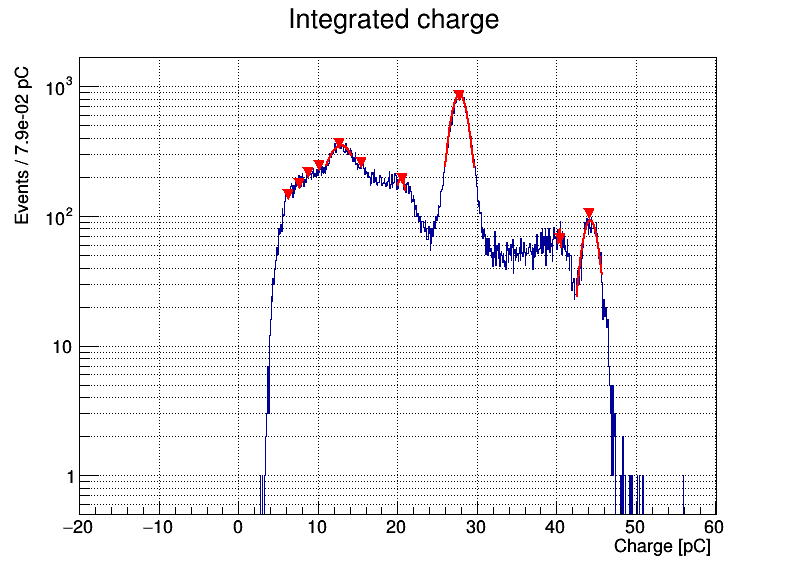

In [80]:
c = rt.TCanvas('c_spectrum', 'c_spectrum', 800, 600)
#rt.gStyle.SetOptFit(000002200)
rt.gStyle.SetOptFit(000002200)
h.SetStats(0)
h.SetTitle('Integrated charge')
h.GetXaxis().SetRangeUser(-20,60)
h.DrawCopy()
c.SetLogy()
c.SetGrid()
c.Draw()


In [81]:
f = cs
Amp_x_R = 50 * 10
content = csv.reader(f)


x = []
y = []
for r in content:
    x.append(1e12*float(r[0]) / Amp_x_R)
    y.append(float(r[1]))

h = rt.TH1F('h', 'h', int(len(x)), x[0], x[-1])
# h.GetXaxis().SetLimits(h.FindBin(-300), h.FindBin(0))
h.SetXTitle('Charge [pC]')
h.SetYTitle('Events / {:1.1e} pC'.format(h.GetBinWidth(1)))
for i in range(len(x)):
    h.SetBinContent(i+1, y[i])
    

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


In [82]:
SS = rt.TSpectrum()
n_pks = SS.Search(h, 0.01, "", 0.005)
x_pos = SS.GetPositionX()
y_pos = SS.GetPositionY()
pks = []
print n_pks
for i in range(n_pks):
    pks.append((x_pos[i],y_pos[i]))
       
pks.sort(key=lambda tup: tup[0])
print pks
# pks_copy = []
# pks_copy.append(pks[n_pks-5])
# pks_copy.append(pks[n_pks-3])
# pks_copy.append(pks[n_pks-2])
# pks = pks_copy
x_pos = []
y_pos = []
pks = [pks[3],pks[4],pks[5]]
for x,y in pks:
    x_pos.append(x)
    y_pos.append(y)
print x_pos,y_pos


6
[(2.340363129973477, 3211.0), (6.497997966401415, 424.0), (9.8071358974359, 368.0), (13.625371971706459, 543.0), (24.061883908045978, 517.0), (32.63170265251989, 1030.0)]
[13.625371971706459, 24.061883908045978, 32.63170265251989] [543.0, 517.0, 1030.0]


In [83]:
Energy = Energy_cs
N_pe = 0*Energy

for i in range(len(x_pos)):
    print i, ':', 'E = {:.3f} MeV'.format(Energy[i])
    n_pk = h.FindBin(x_pos[i])
    
    if i == 0 or i==1:
        thr = 0.8 * h.GetBinContent(n_pk)
    else:
        thr = 0.3 * h.GetBinContent(n_pk)   
    
    n_up = n_pk
    while h.GetBinContent(n_up) > thr:
        n_up += 1
    x_up = h.GetBinCenter(n_up)
    
    r = h.Fit('gaus', 'LRSQ+', '', x_pos[i]-(x_up-x_pos[i]), x_up)
    r = r.Get()
    
    saturation.SetPoint(int(i)+4, Energy[i], r.Parameter(1)*Ch2N/gain)#number of photoelectron
    saturation.SetPointError(int(i)+4, 0, r.ParError(1)*Ch2N/gain)
    if i==0 or 1:
        linear.SetPoint(int(i)+1, Energy[i], r.Parameter(1)*Ch2N/gain)#number of electrons
        linear.SetPointError(int(i)+1, 0, r.ParError(1)*Ch2N/gain)
    print('saturation points,' ,r.Parameter(1)*Ch2N/gain)
    print 'Deposited charge: {:.1f} pC (Ne = {:.0f}M)'.format(r.Parameter(1), 1e-6*r.Parameter(1)*Ch2N)
    print 'Fit p-val = {:.2f}'.format(r.Prob())
    print(r.Parameter(1))
    print 'N_pe: {:.0f}'.format(r.Parameter(1)*Ch2N / (gain*Energy[i]))
    print 'N_ph: {:.0f}'.format(r.Parameter(1)*Ch2N / (gain*PDE*Energy[i]))
    print 'uncertainty in N_ph {:.0f}'.format(r.ParError(1)*Ch2N / (gain*PDE*Energy[i]))
    print 'uncertainty in pC {:.0f}'.format(r.ParError(1)*1000)


    N_pe[i] = r.Parameter(1)*Ch2N / (gain * Energy[i])
    
    integral = r.Parameter(0) * np.sqrt(2*np.pi) * r.Parameter(2) / h.GetBinWidth(1)
    print 'Estimated number of decays: {:.0f}'.format(integral)
    
    print '\n'
# linear.SetPoint(3,0.0,0.0)

0 : E = 0.185 MeV
('saturation points,', 1046.6522023665152)
Deposited charge: 13.7 pC (Ne = 86M)
Fit p-val = 0.72
13.7463281114
N_pe: 5658
N_ph: 11315
uncertainty in N_ph 32
uncertainty in pC 39
Estimated number of decays: 41930


1 : E = 0.477 MeV
('saturation points,', 1810.7191349102743)
Deposited charge: 23.8 pC (Ne = 149M)
Fit p-val = 0.68
23.7812898018
N_pe: 3796
N_ph: 7592
uncertainty in N_ph 22
uncertainty in pC 69
Estimated number of decays: 51020


2 : E = 0.662 MeV
('saturation points,', 2483.238735398498)
Deposited charge: 32.6 pC (Ne = 204M)
Fit p-val = 0.43
32.613903987
N_pe: 3751
N_ph: 7502
uncertainty in N_ph 2
uncertainty in pC 7
Estimated number of decays: 30490




Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_spectrum


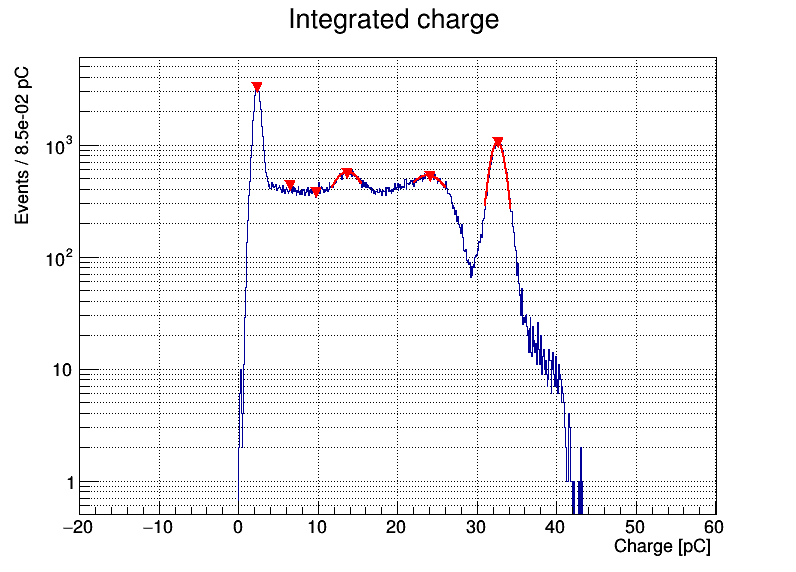

In [84]:
c = rt.TCanvas('c_spectrum', 'c_spectrum', 800, 600)
#rt.gStyle.SetOptFit(000002200)
rt.gStyle.SetOptFit(000002200)
h.SetStats(0)
h.SetTitle('Integrated charge')
h.GetXaxis().SetRangeUser(-20,60)
h.DrawCopy()
c.SetLogy()
c.SetGrid()
c.Draw()




p-val = 0.000
 FCN=2873.58 FROM MIGRAD    STATUS=CONVERGED     144 CALLS         145 TOTAL
                     EDM=1.12975e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.6 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           3.75926e+03   6.00709e+00   1.55446e-03  -2.95156e-05
   2  p1           1.62642e+00   4.47534e-03   4.54295e-07   1.00397e-01


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_gain


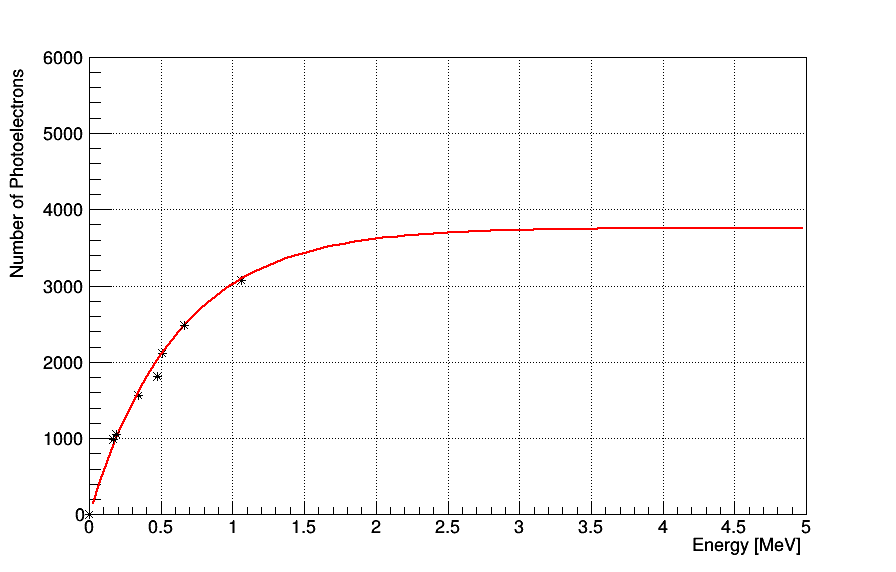

In [88]:
multi.Add(saturation)
multi.Add(linear)


# fit = rt.TF1("myfit","[0]-[1]*exp(-[2]*x)",0,1)
fit = rt.TF1("myfit","[0]*(1-exp(-[1]*x))",0,4)
fit.SetParameter(0,3000)
fit.SetParameter(2,2000)
r = saturation.Fit(fit, 'S')

r = r.Get()
fit = saturation.GetFunction('myfit')
fit.SetRange(0,5)
print 'p-val = {:.3f}'.format(r.Prob())

# r = linear.Fit('pol1', 'S')
# r = r.Get()

# print 'p-val = {:.3f}'.format(r.Prob())

c_gain = rt.TCanvas('c_gain', 'c_gain', 900, 600)
# saturation.Draw('AP*E1')
saturation.SetTitle("")
multi.GetYaxis().SetTitle('Number of Photoelectrons')
multi.GetXaxis().SetTitle('Energy [MeV]')
rt.gStyle.SetOptFit(0)
multi.GetYaxis().SetRangeUser(0,6000)
# multi.SetStats(0)

multi.Draw('AP*E1')

# fit.Draw()


multi.GetXaxis().SetLimits(0,5)


# linear.Draw()
c_gain.SetGrid()
# c_gain.SetLogy()
c_gain.Draw()